In [1]:
import pandas as pd
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, mapping
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import regionmask
import xesmf as xe
import cmocean

from matplotlib import ticker

import sys
sys.path.append('../')
import utils
import plotting

import math

In [2]:
import string
alphabet = list(string.ascii_lowercase)


# Import Data and Count mortalities

In [3]:
ds_o3 = xr.open_zarr('./final_data/o3_mortalities.zarr')
ds_PM = xr.open_zarr('./final_data/pm_mortalities.zarr')

In [4]:
for ids in ['mean','low','high']:
    print('ozone')
    print('nonuc', ids, ds_o3.sel(model_name = 'nonuc_NA')[f'Δmortality_{ids}'].sum().values)
    print('nonuc_coal', ids, ds_o3.sel(model_name = 'nonuc_coal_NA')[f'Δmortality_{ids}'].sum().values)
    print('renew_nonuc', ids, ds_o3.sel(model_name = 'renew_nonuc_NA')[f'Δmortality_{ids}'].sum().values)

    print('PM25')
    print('nonuc', ids, ds_PM.sel( model_name = 'nonuc_NA')[f'Δmortality_{ids}'].sum().values)
    print('nonuc_coal', ids, ds_PM.sel(model_name = 'nonuc_coal_NA')[f'Δmortality_{ids}'].sum().values)
    print('renew_nonuc', ids, ds_PM.sel(model_name = 'renew_nonuc_NA')[f'Δmortality_{ids}'].sum().values)

ozone
nonuc mean 1582.627526030105
nonuc_coal mean 4329.621037288911
renew_nonuc mean -715.983649727164
PM25
nonuc mean 3647.3295769388715
nonuc_coal mean 3768.46710405221
renew_nonuc mean 983.6841535116325
ozone
nonuc low 795.231221887837
nonuc_coal low 2175.527577503445
renew_nonuc low -359.76409057693536
PM25
nonuc low 2756.9363149324818
nonuc_coal low 2944.1801843465196
renew_nonuc low 753.7339298044988
ozone
nonuc high 3134.5224701011643
nonuc_coal high 8575.166427470975
renew_nonuc high -1418.0638219558846
PM25
nonuc high 4574.657311965098
nonuc_coal high 4630.142721153974
renew_nonuc high 1223.979504660938


## monetization of the health impacts


In [5]:
#convert from 2006 dollars to 2007
conversion = 1.0285

In [6]:
VSL = 7.4E6
print('nonuc, O3: ', "{:e}".format((ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_NA').sum()*VSL*conversion).values))
print('nonuc/coal, O3: ',"{:e}".format((ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA').sum()*VSL*conversion).values))
print('nonuc+renew, O3: ',"{:e}".format((ds_o3['Δmortality_mean'].sel(model_name = 'renew_nonuc_NA').sum()*VSL*conversion).values))


print('nonuc, PM: ',"{:e}".format((ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_NA').sum()*VSL*conversion).values))
print('nonuc/coal, PM: ',"{:e}".format((ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA').sum()*VSL*conversion).values))
print('nonuc+renew, PM: ',"{:e}".format((ds_PM['Δmortality_mean'].sel(model_name = 'renew_nonuc_NA').sum()*VSL*conversion).values))


nonuc, O3:  1.204522e+10
nonuc/coal, O3:  3.295231e+10
nonuc+renew, O3:  -5.449280e+09
nonuc, PM:  2.775946e+10
nonuc/coal, PM:  2.868143e+10
nonuc+renew, PM:  7.486722e+09


# Plot

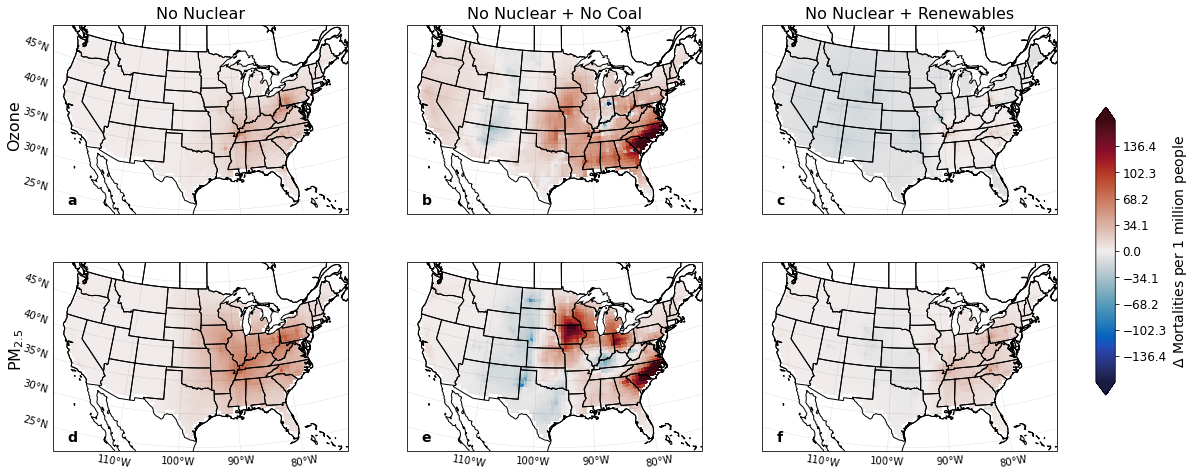

In [8]:
fig = plt.figure(figsize=[18,8])
###O3 No Nuclear plot ###
lev = np.squeeze(np.arange(-170,170.1,.1))
cmap = cmocean.cm.balance
ax_o3 = fig.add_subplot(2,3,1, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3['Δmortality_mean'].sel( model_name = 'nonuc_NA')/ds_o3['regrid_pop_count']).plot(ax = ax_o3,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3.set_title('No Nuclear', fontsize = 16)
ax_o3.add_feature(cfeat.STATES)
ax_o3.coastlines()
ax_o3.set_extent(plotting.lat_lon)

gl = ax_o3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

###O3 No Nuclear No Coal plot ###

ax_o3_coal = fig.add_subplot(2,3,2, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_o3['regrid_pop_count']).plot(ax = ax_o3_coal,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_coal.set_title('No Nuclear + No Coal', fontsize = 16)
ax_o3_coal.add_feature(cfeat.STATES)
ax_o3_coal.coastlines()
ax_o3_coal.set_extent(plotting.lat_lon)

gl = ax_o3_coal.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

###O3 No Nuclear + Renewables plot ###

ax_o3_renew = fig.add_subplot(2,3,3, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3['Δmortality_mean'].sel(model_name = 'renew_nonuc_NA')/ds_o3['regrid_pop_count']).plot(ax = ax_o3_renew,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_renew.set_title('No Nuclear + Renewables', fontsize = 16)
ax_o3_renew.add_feature(cfeat.STATES)
ax_o3_renew.coastlines()
ax_o3_renew.set_extent(plotting.lat_lon)

gl = ax_o3_renew.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

###PM No Nuclear plot ###

ax_pm = fig.add_subplot(2,3,4, projection=ccrs.LambertConformal())
(1e6*ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_NA')/ds_PM['regrid_pop_count']).plot(ax = ax_pm, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm.set_title(r' ', fontsize = 16)
ax_pm.add_feature(cfeat.STATES)
ax_pm.coastlines()
ax_pm.set_extent(plotting.lat_lon)

gl = ax_pm.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

###PM No Nuclear Renewables plot ###
ax_pm_coal = fig.add_subplot(2,3,5, projection=ccrs.LambertConformal())
(1e6*ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_PM['regrid_pop_count']).plot(ax = ax_pm_coal, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_coal.set_title(r' ', fontsize = 16)
ax_pm_coal.add_feature(cfeat.STATES)
ax_pm_coal.coastlines()
ax_pm_coal.set_extent(plotting.lat_lon)

gl = ax_pm_coal.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

###PM No Nuclear + Renewables plot ###
ax_pm_renew = fig.add_subplot(2,3,6, projection=ccrs.LambertConformal())
(1e6*ds_PM['Δmortality_mean'].sel(model_name = 'renew_nonuc_NA')/ds_PM['regrid_pop_count']).plot(ax = ax_pm_renew, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_renew.set_title(r' ', fontsize = 16)
ax_pm_renew.add_feature(cfeat.STATES)
ax_pm_renew.coastlines()
ax_pm_renew.set_extent(plotting.lat_lon)

gl = ax_pm_renew.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

for label, ax in zip(alphabet, [ax_o3, ax_o3_coal, ax_o3_renew, ax_pm, ax_pm_coal, ax_pm_renew]):
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)


###colorbar 
cbar_ax = fig.add_axes([.93, 0.23, 0.015, 0.5])
cb = fig.colorbar(pc, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 

cb.set_label(label = '$\Delta$ Mortalities per 1 million people', fontsize=14)
cb.ax.tick_params(labelsize='large')

fig.text(.09,.66,'Ozone', fontsize = 16, rotation = 'vertical')
fig.text(.09,.28,'PM$_{2.5}$', fontsize = 16, rotation = 'vertical')

plt.savefig('./Figures/mortalities.png', bbox_inches = 'tight', dpi = 150)